*First compiled on April 25, 2018. Updated June 8, 2018.*

# PAGA for hematopoiesis in mouse [(Dahlin *et al.*, 2018)](https://doi.org/10.1182/blood-2017-12-821413)

The preprocessed data from the original publication is available from [here](https://drive.google.com/drive/folders/10B5d8hpWQdtmqpnhX-Gfx3seh4qSNInF?usp=sharing).

In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
from scipy.stats import mode
from collections import Counter

sc.settings.verbosity = 3
sc.set_figure_params(color_map='viridis')
sc.logging.print_versions()
results_file = './write/dahlin.h5ad'

scanpy==1.2.0 anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


Read in data as preprocessed for [Dahlin *et al.* (2018)](https://doi.org/10.1182/blood-2017-12-821413).

In [2]:
adata = sc.read('./data/scanpy_processed_matrix_both_no_cc.h5ad')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We don't actually need the scaled counts. Let's save some disk space and memory and set it to `None`.

In [3]:
adata.X = None

Instead add the raw counts for visualization.

In [4]:
adata_raw = sc.read('./data/scanpy_filtered_all_genes_matrix_both.h5ad')
adata_raw.var_names_make_unique()
sc.pp.log1p(adata_raw)
adata.raw = adata_raw

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Compute the graph using 20 PCs and 7 neighbors as in [Dahlin *et al.* (2018)](https://doi.org/10.1182/blood-2017-12-821413).

In [5]:
sc.pp.neighbors(adata, n_neighbors=7, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:11.12) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Compute PAGA for some clustering for basic visualization.

In [6]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:05.00) --> found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [7]:
sc.tl.paga(adata)

... storing 'sample' as categorical
... storing 'exp_groups' as categorical
... storing 'erythroid_cc_group' as categorical
running partition-based graph abstraction (PAGA)
    finished (0:00:02.59) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


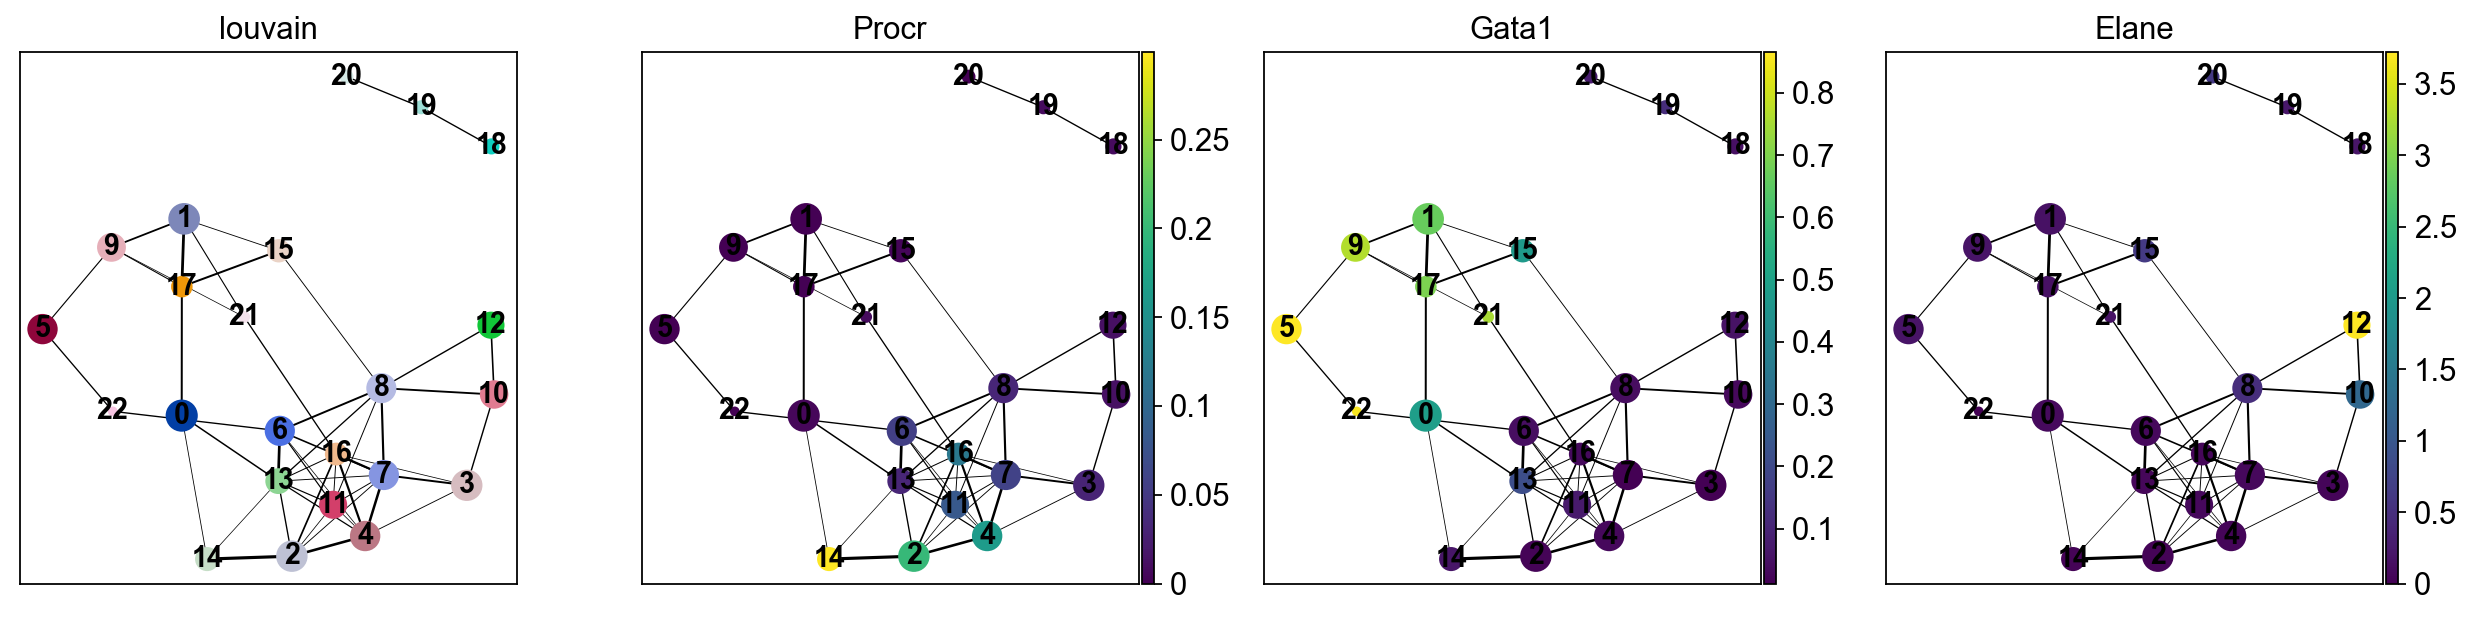

In [8]:
sc.pl.paga(adata, color=['louvain', 'Procr', 'Gata1', 'Elane'], edge_width_scale=0.2, threshold=0.2)

Compute UMAP for basic visualization.

In [9]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:33.14) --> added
    'X_umap', UMAP coordinates (adata.obsm)


Clip a few outliers that extend far down the plot.

In [10]:
adata.obsm['X_umap'][:, 1] = np.clip(adata.obsm['X_umap'][:, 1], a_min=-20, a_max=None)

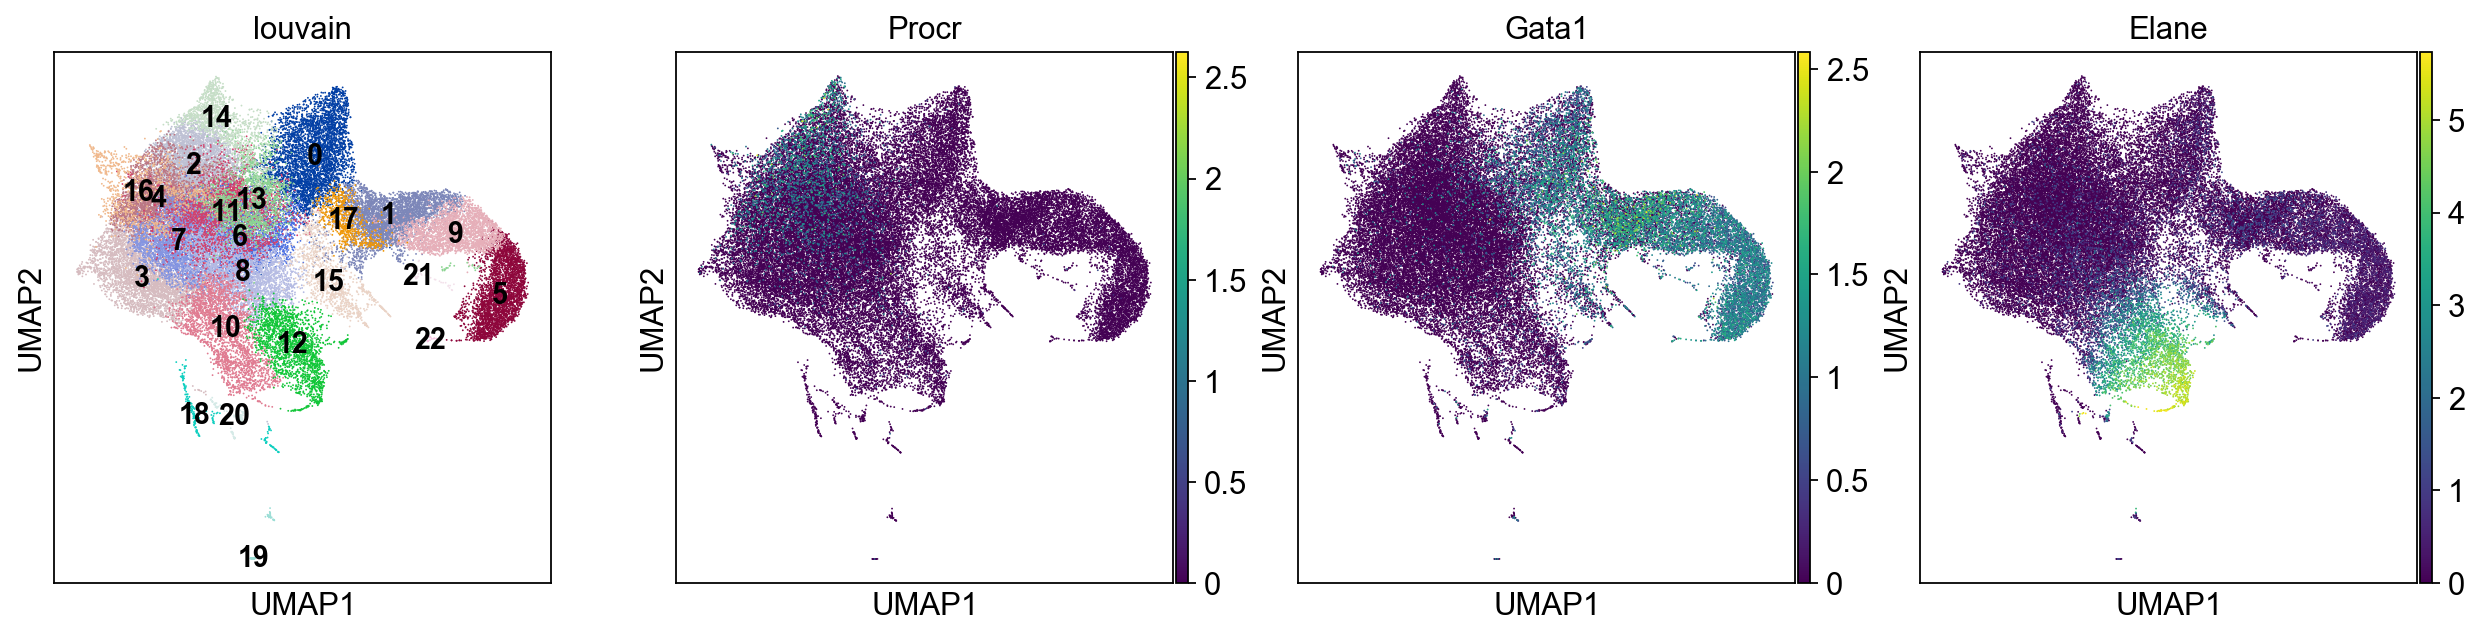

In [11]:
sc.pl.umap(adata, color=['louvain', 'Procr', 'Gata1', 'Elane'], legend_loc='on data')

Recompute the graph using diffusion maps. Truncating at a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components; this is very similar to denoising a data matrix using PCA.

In [12]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [ 1.            0.9991334677  0.9973362088  0.9968386889  0.9964612126
      0.9963735938  0.9945415854  0.9944582582  0.9938271642  0.993545115
      0.9903064966  0.9890737534  0.9883710742  0.9880910516  0.9874891043]
    finished (0:00:05.21) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing neighbors
    finished (0:00:10.80) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


We could now visualize the denoised graph using UMAP again. However, here, we prefer to work with the familiar visualization above, which pretty closely resembles the one from the original publication.

## Clustering

In [13]:
sc.tl.louvain(adata, resolution=0.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:06.78) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


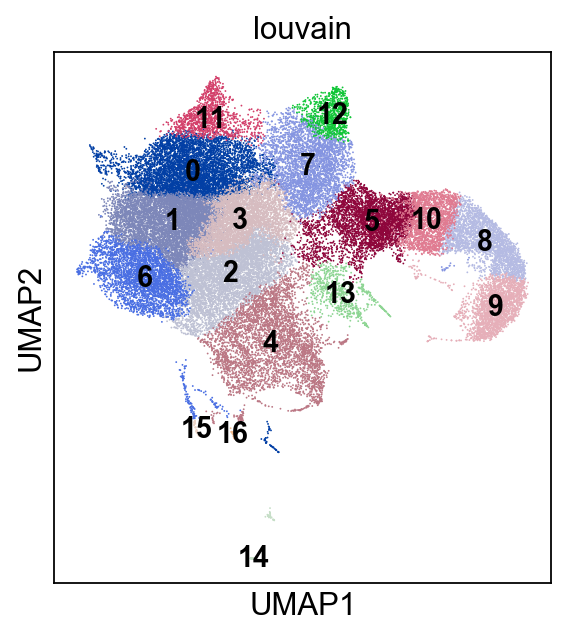

In [14]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

Increase the resolution in cluster 4 and 13 a bit more.

In [15]:
sc.tl.louvain(adata, resolution=0.03, restrict_to=('louvain', ['4', '13']))

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.38) --> found 4 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


In [16]:
adata.obs['louvain_R'].cat.categories = [str(i) for i in range(len(adata.obs['louvain_R'].cat.categories))]

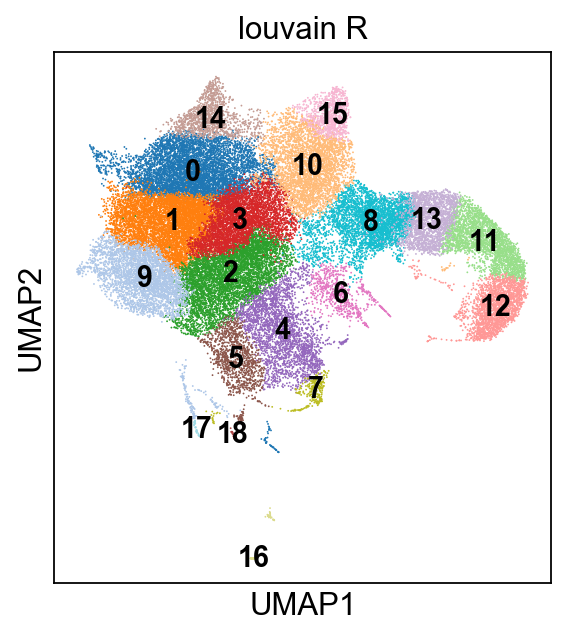

In [17]:
sc.pl.umap(adata, color='louvain_R', legend_loc='on data')

Some marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

Let's identify the clusters by comparing with the marker genes.

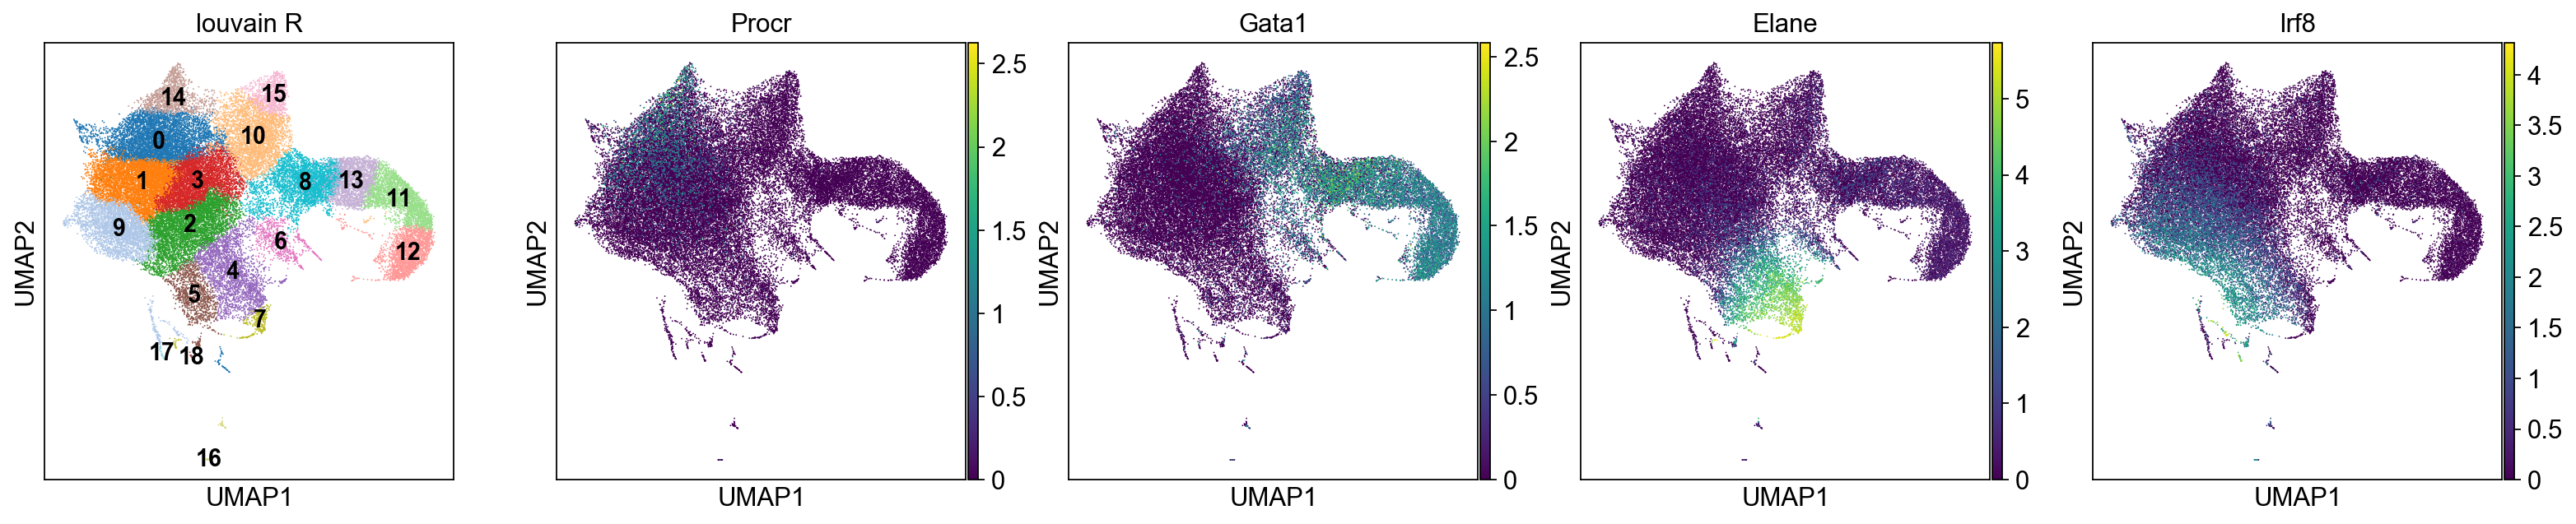

In [18]:
sc.pl.umap(adata, color=['louvain_R', 'Procr', 'Gata1', 'Elane', 'Irf8'], legend_loc='on data')

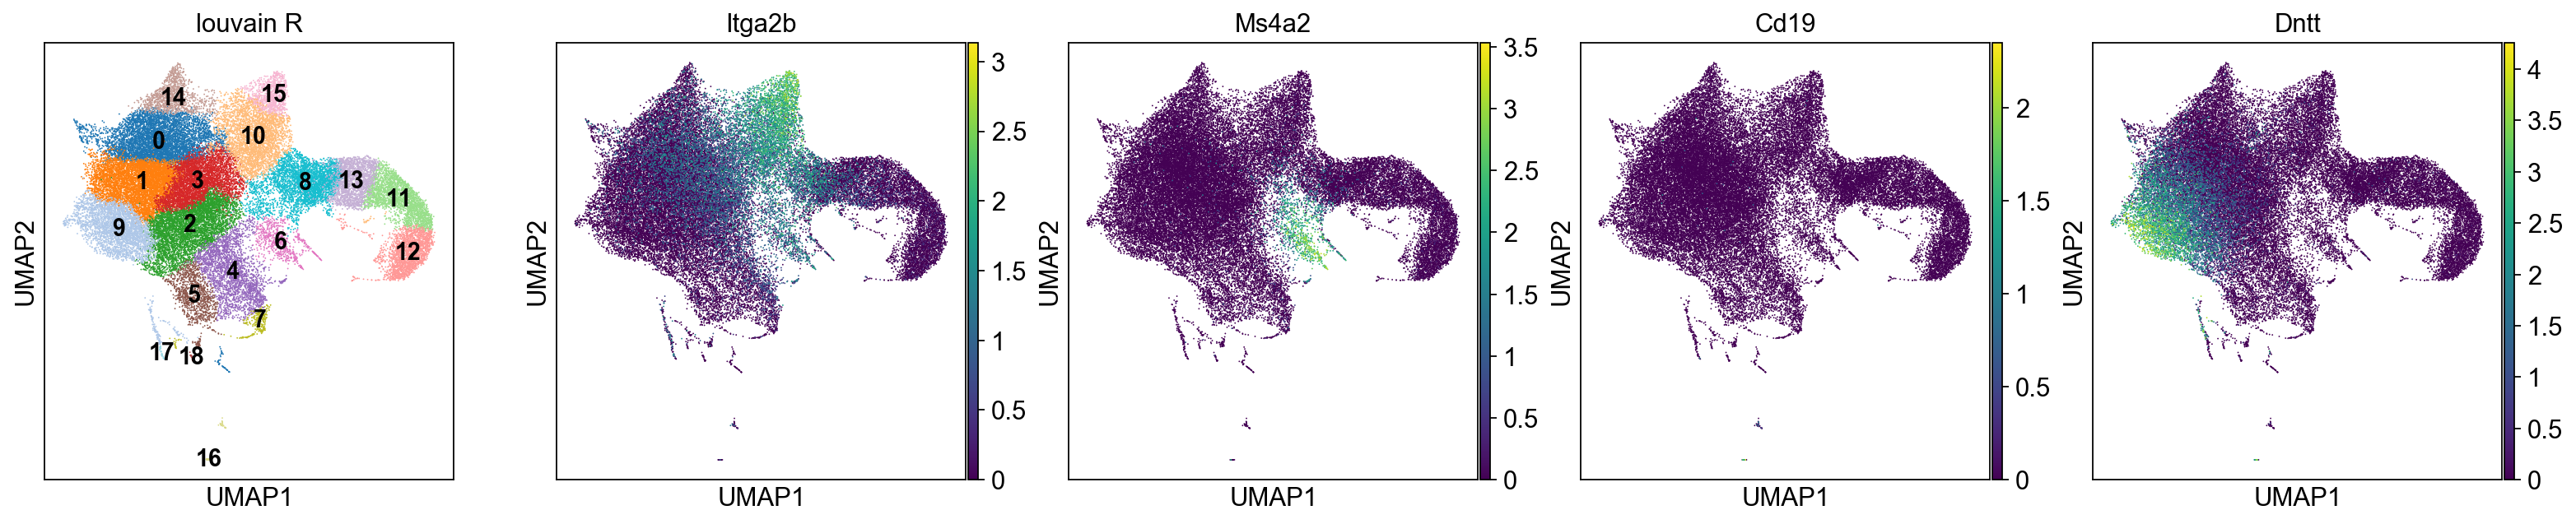

In [19]:
sc.pl.umap(adata, color=['louvain_R', 'Itga2b', 'Ms4a2', 'Cd19', 'Dntt'], legend_loc='on data')

In [20]:
adata.obs['clusters'] = adata.obs['louvain_R']

In [21]:
adata.obs['louvain_R'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18'],
      dtype='object')

In [22]:
adata.obs['clusters'].cat.categories = [
    '0', '1', '2', '3', '4', '5/Mo', '6/Baso', '7/Neu', '8', '9/Lymph', '10', '11', '12/Ery',
    '13', '14/Stem', '15/Mk', '16/B', '17', '18']

In [23]:
sc.tl.paga(adata, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:02.80) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


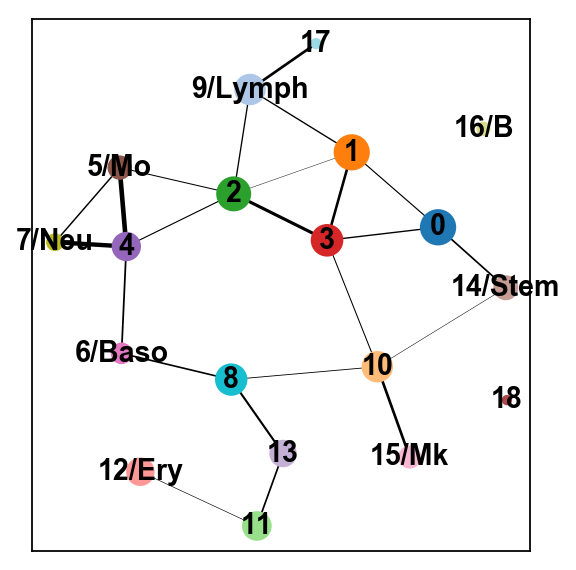

In [24]:
sc.pl.paga(adata, threshold=0.02, edge_width_scale=1, layout='fr', random_state=0)

In [25]:
pos = adata.uns['paga']['pos']

In [26]:
pos[6] = [-14,   5]
pos[12] = [-10, -5]

--> added 'pos', the PAGA positions (adata.uns['paga'])


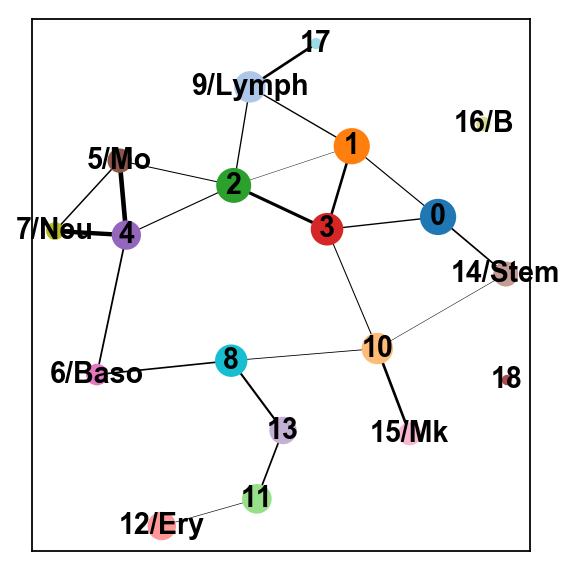

In [27]:
sc.pl.paga(adata, threshold=0.02, edge_width_scale=1, layout='fr', pos=pos)

In [28]:
sc.tl.umap(adata, init_pos='paga')

computing UMAP
    finished (0:00:35.03) --> added
    'X_umap', UMAP coordinates (adata.obsm)


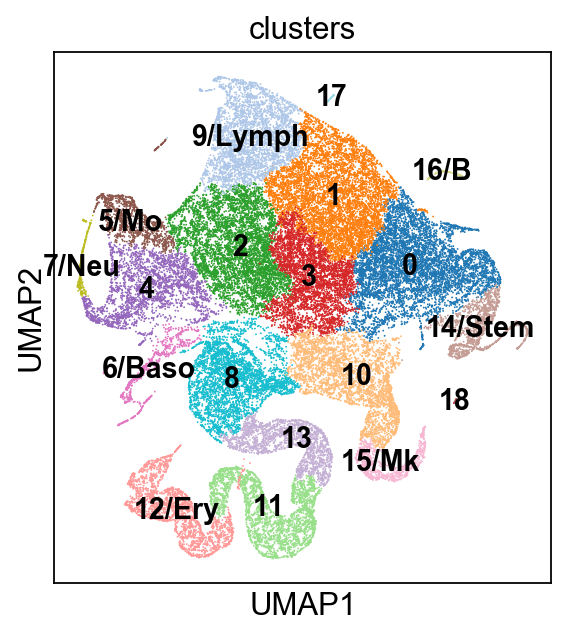

In [29]:
sc.pl.umap(adata, color='clusters', legend_loc='on data')

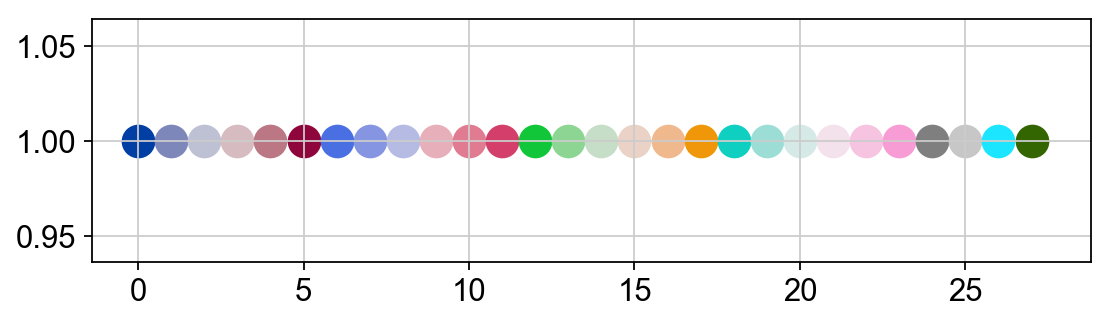

In [30]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [31]:
orig_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = orig_colors.copy()

In [32]:
new_colors[[14, 0, 3, 1]] = orig_colors[[12, 13, 14, 14]]  # Stem colors / green
new_colors[[12, 11, 13, 8, 10]] = orig_colors[[5, 11, 10, 9, 21]]  # Ery colors / red
new_colors[[15]] = orig_colors[[17]]  # Mk early Ery colors / yellow
new_colors[[2, 9, 4, 1]] = orig_colors[[2, 8, 1, 25]]  # lymph progenitors / grey
new_colors[[6]] = orig_colors[[18]]  # Baso / turquoise
new_colors[[7]] = orig_colors[[6]]  # Neu / light blue
new_colors[[5]] = orig_colors[[0]]  # Mo / dark blue

In [33]:
adata.uns['clusters_colors'] = new_colors

In [48]:
adata.rename_categories(
    'clusters',
    ['0', '1', '2', '3', '4', '5/Mo             ', '\n6/Baso                ', '\n\n7/Neu', '8', '9/Lymph\n\n', '10',
     '11', '12/Ery\n\n', '13', '                14/Stem\n', '           15/Mk\n', '16/B\n\n', '17', '18'])

In [49]:
axs = sc.pl.paga_compare(
    adata, title='', right_margin=0.2, size=10,
    threshold=0.02,
    legend_fontsize=12, fontsize=12, frameon=False, show=False)

--> added 'pos', the PAGA positions (adata.uns['paga'])


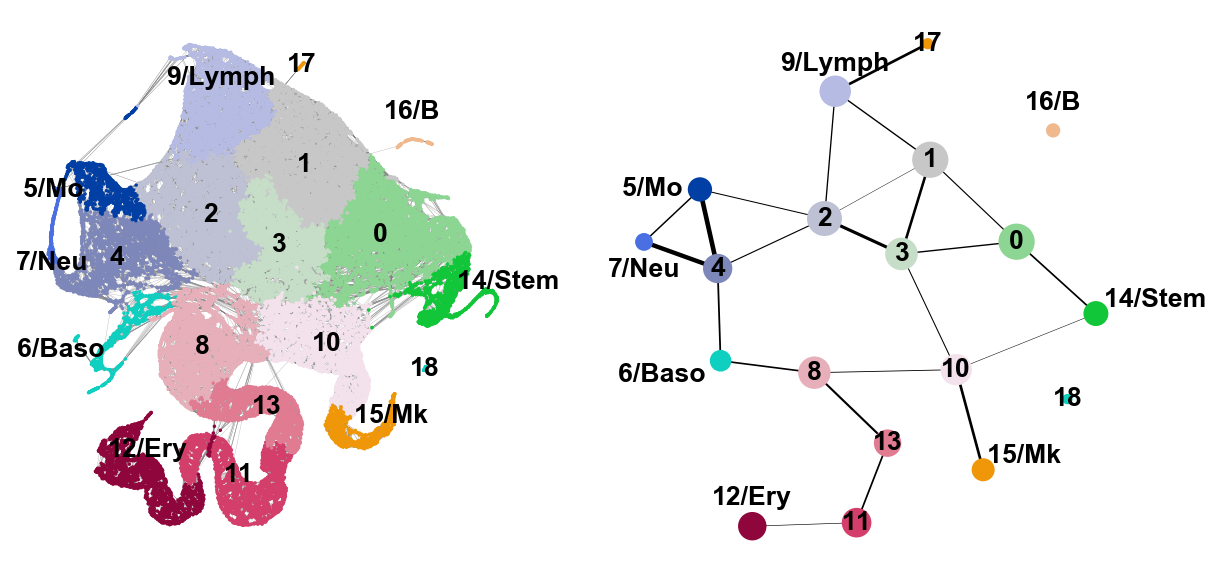

In [50]:
pl.sca(axs[0])
pl.xlabel('')
pl.ylabel('')
axs[0].set_frame_on(False)
pl.savefig('./figures/paga_compare_dahlin18.pdf')
pl.show()

In [51]:
adata.write(results_file)

There are some disconnected clusters but these correspond to very rare populations, and at least in some cases may be contaminating mature cells.

The mast cell/basophils are connected to both cluster 2 (myeloid progenitors) and cluster 7 (erythroid progenitors). Both possibilities have been seen in the literature.

### Reconstruct gene changes along paths for some marker genes.

Identify cell with highest expression of *Procr* for root cell.

In [52]:
adata = sc.read(results_file)
root_cell = int(np.where(adata.raw[:, 'Procr'].X == float(np.max(adata.raw[:, 'Procr'].X)))[0])
print(adata.obs['clusters'][root_cell])
adata.uns['iroot'] = root_cell

                14/Stem



In [53]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.01) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


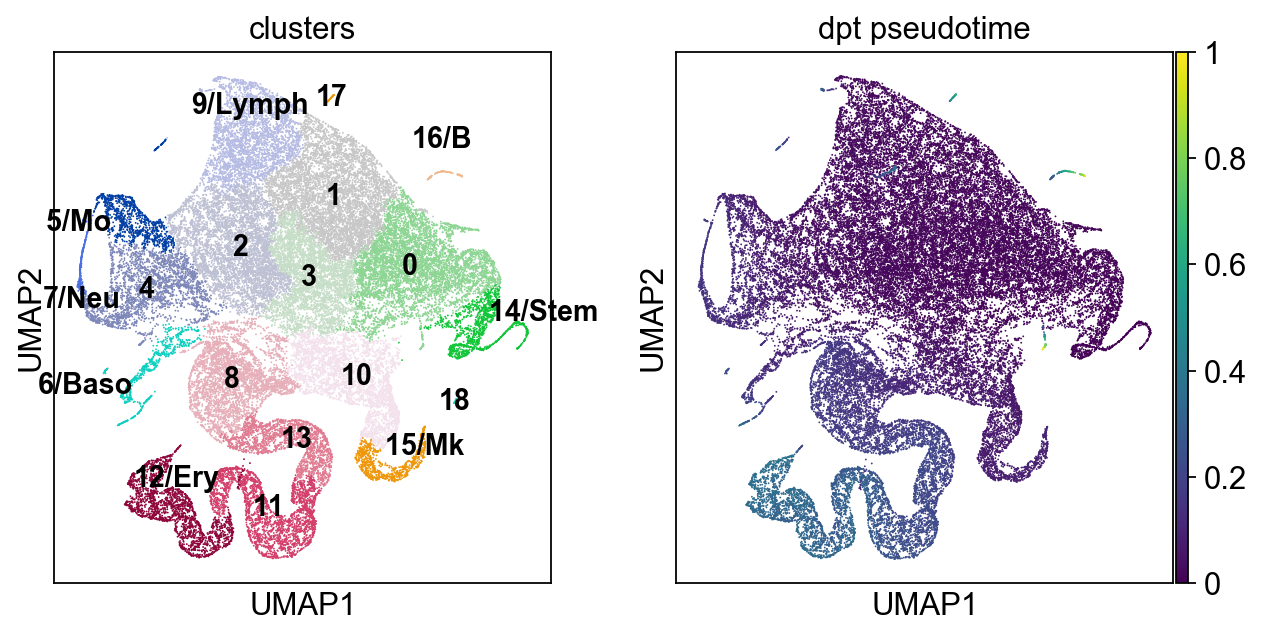

In [54]:
sc.pl.umap(adata, color=['clusters', 'dpt_pseudotime'], legend_loc='on data')

Look at marker genes along some trajectories

In [74]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [75]:
paths = [('erythrocytes', [14, 0, 3, 10, 8, 13, 11, 12]),
         ('neutrophils', [14, 0, 1, 2, 4, 7]),
         ('monocytes', [14, 0, 1, 2, 5])]

In [76]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [77]:
adata.raw = sc.AnnData(sc.pp.scale(adata.raw.X, copy=True),
                       var=adata.raw.var)

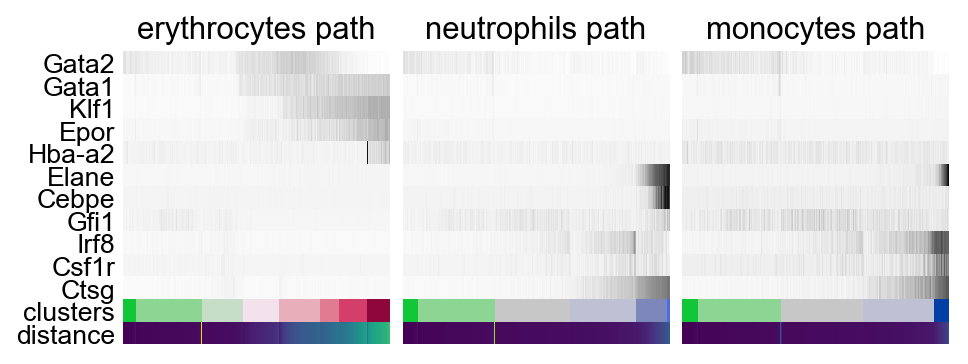

In [78]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_dahlin18.pdf')
pl.show()